In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# to read the data
import pandas as pd

1. Choose two simple dataset of binary classification, these datasets data must be with classes that are separated linearly
with a bit of noise, one which is 2 D and the other 3 D 

In [2]:
# read the data from csv file
twod_data = pd.read_csv('2d_noise_data.csv')
threed_data = pd.read_csv('3d_noise_data.csv')

In [3]:
# extract the features and labels
X_two_d = twod_data.iloc[:, [0, 1]].values
y_two_d = twod_data.iloc[:, 2].values

X_three_d = threed_data.iloc[:, [0, 1, 2]].values
y_three_d = threed_data.iloc[:, 3].values

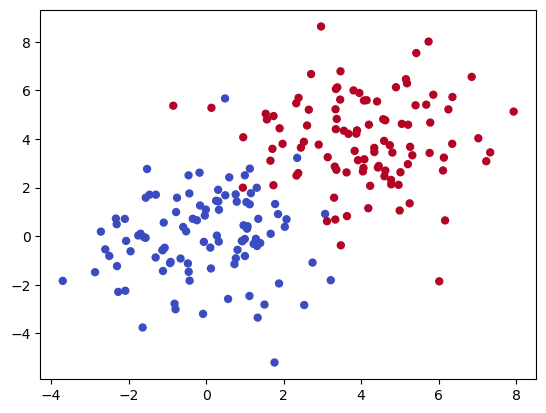

In [4]:
# Visualising the 2d data 
plt.scatter(X_two_d[:, 0], X_two_d[:, 1], c=y_two_d, cmap=plt.cm.coolwarm, s=25)
plt.show()

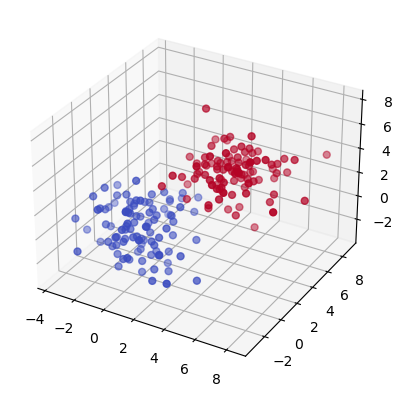

In [5]:
# Visualising the 3d data
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_three_d[:, 0], X_three_d[:, 1], X_three_d[:, 2], c=y_three_d, cmap=plt.cm.coolwarm, s=25)
plt.show()  

3. Split data into train and test

In [6]:
# first we shuffle the data using numpy

# shuffle the 2d data 
np.random.seed(0)
shuffle_index = np.random.permutation(len(X_two_d))
X_two_d, y_two_d = X_two_d[shuffle_index], y_two_d[shuffle_index]

# shuffle the 3d data
np.random.seed(0)
shuffle_index = np.random.permutation(len(X_three_d))
X_three_d, y_three_d = X_three_d[shuffle_index], y_three_d[shuffle_index]

In [7]:
# split the data into training and testing 0.8:0.2
X_train_two_d, X_test_two_d = X_two_d[:80], X_two_d[80:]
y_train_two_d, y_test_two_d = y_two_d[:80], y_two_d[80:]

X_train_three_d, X_test_three_d = X_three_d[:80], X_three_d[80:]
y_train_three_d, y_test_three_d = y_three_d[:80], y_three_d[80:]

4-5 Implement the SMO optimization algorithm with Soft Margin SVC and Hard Margin SVC

to implement the Hard margin SVC it is enough to take a very big value for C

In [8]:
def soft_margin_svc_smo(X, y, C, eps, max_iter):
    """
    Implementation of the SMO algorithm for solving SVMs.

    Args:
        train_X: The training data, shape (n_samples, n_features).
        train_y: The training labels, shape (n_samples,).
        C: The regularization strength.
        eps: The tolerance for stopping criterion.
        max_iter: The maximum number of iterations.

    Returns:
        alpha: The Lagrange multipliers, shape (n_samples,).
        b: The bias term.
        w: The weights, shape (n_features,).
    """

    n_samples = X.shape[0]

    # Initialize alpha to 0
    alpha = np.zeros(n_samples)
    
    # Initialize b to 0
    b = 0
    
    k = 0
    while k < max_iter:
        alpha_prev = np.copy(alpha)

        for i in range(n_samples):
            # Compute the error for the i-th sample
            Ei = np.sum(alpha * y * X.dot(X[i])) + b - y[i]

            # Select the second sample j to update
            j = np.random.randint(0, n_samples)
            while j == i:
                j = np.random.randint(0, n_samples)

            # Compute the error for the j-th sample
            Ej = np.sum(alpha * y * X.dot(X[j])) + b - y[j]

            # Compute the lower and upper bounds for alpha[j]
            if y[i] != y[j]:
                L = max(0, alpha[j] - alpha[i])
                H = min(C, C + alpha[j] - alpha[i])
            else:
                L = max(0, alpha[i] + alpha[j] - C)
                H = min(C, alpha[i] + alpha[j])

            # Check if L and H are equal
            if L == H:
                continue

            # Compute the learning rate eta
            eta = 2 * X[i].dot(X[j]) - X[i].dot(X[i]) - X[j].dot(X[j])
            if eta >= 0:
                continue

            # Update alpha[j] and clip it to the [L, H] range
            alpha[j] -= y[j] * (Ei - Ej) / eta
            alpha[j] = np.clip(alpha[j], L, H)

            # Update alpha[i]
            alpha[i] += y[i] * y[j] * (alpha_prev[j] - alpha[j])

            # Update the bias b
            b1 = b - Ei - y[i] * (alpha[i] - alpha_prev[i]) * X[i].dot(X[i]) - \
                 y[j] * (alpha[j] - alpha_prev[j]) * X[i].dot(X[j])
            b2 = b - Ej - y[i] * (alpha[i] - alpha_prev[i]) * X[i].dot(X[j]) - \
                 y[j] * (alpha[j] - alpha_prev[j]) * X[j].dot(X[j])
            if 0 < alpha[i] < C:
                b = b1
            elif 0 < alpha[j] < C:
                b = b2
            else:
                b = (b1 + b2) / 2

        # Check for convergence
        diff = np.linalg.norm(alpha - alpha_prev)
        if diff < eps:
            break

        k += 1

    return alpha, b

### Soft Margin SVC

2D Data

In [9]:
soft_alpha_two_d, soft_b_two_d = soft_margin_svc_smo(X_train_two_d, y_train_two_d, C=1, eps=1e-5, max_iter=1000)

In [10]:
# Compute the weights
soft_w_two_d = np.sum((soft_alpha_two_d * y_train_two_d)[:, None] * X_train_two_d, axis=0)

# compute the bias
soft_b_two_d = np.mean(y_train_two_d - soft_w_two_d.dot(X_train_two_d.T))

In [11]:
# compute the predictions
soft_y_pred_two_d = - np.sign(X_test_two_d.dot(soft_w_two_d) + soft_b_two_d)

In [12]:
# calculate the accuracy
accuracy_two_d = np.mean(soft_y_pred_two_d == y_test_two_d)

print('Accuracy of Soft Margin SVC in the 2D data : {:.2f} %'.format(accuracy_two_d* 100))

Accuracy of Soft Margin SVC in the 2D data : 93.33 %


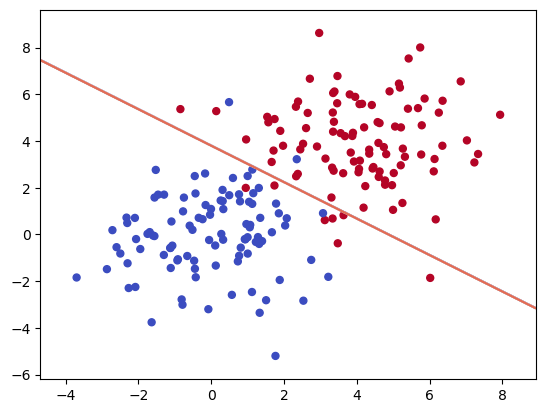

In [13]:
# visualize the decision boundary
plt.scatter(X_two_d[:, 0], X_two_d[:, 1], c=y_two_d, cmap=plt.cm.coolwarm, s=25)

# plot the decision boundary
x_min, x_max = X_two_d[:, 0].min() - 1, X_two_d[:, 0].max() + 1
y_min, y_max = X_two_d[:, 1].min() - 1, X_two_d[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

Z = soft_w_two_d.dot(np.c_[xx.ravel(), yy.ravel()].T) + soft_b_two_d
Z = np.sign(Z).reshape(xx.shape)

plt.contour(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
plt.show()

3D Data

In [14]:
soft_alpha_two_d, soft_b_two_d = soft_margin_svc_smo(X_train_three_d, y_train_three_d, C=1, eps=1e-5, max_iter=1000)


In [15]:
# Compute the weights
soft_w_three_d = np.sum((soft_alpha_two_d * y_train_three_d)[:, None] * X_train_three_d, axis=0)

# compute the bias
soft_b_three_d = np.mean(y_train_three_d - soft_w_three_d.dot(X_train_three_d.T))

In [16]:
# compute the predictions
soft_y_pred_three_d = - np.sign(X_test_three_d.dot(soft_w_three_d) + soft_b_three_d)

In [17]:
# calculate the accuracy
accuracy_three_d = np.mean(soft_y_pred_three_d == y_test_three_d)

print('Accuracy of Soft Margin SVC in the 3D data : {:.2f} %'.format(accuracy_three_d* 100))

Accuracy of Soft Margin SVC in the 3D data : 97.50 %


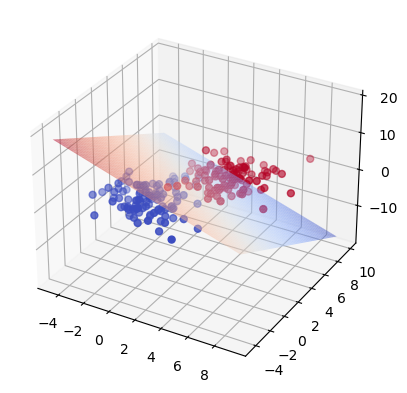

In [18]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_three_d[:, 0], X_three_d[:, 1], X_three_d[:, 2], c=y_three_d, cmap=plt.cm.coolwarm, s=25)

# plot the hyperplan decision boundary
x_min, x_max = X_three_d[:, 0].min() - 1, X_three_d[:, 0].max() + 1
y_min, y_max = X_three_d[:, 1].min() - 1, X_three_d[:, 1].max() + 1
z_min, z_max = X_three_d[:, 2].min() - 1, X_three_d[:, 2].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
Z = (-soft_w_three_d[0]*xx - soft_w_three_d[1]*yy - soft_b_three_d) / soft_w_three_d[2]

ax.plot_surface(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.5)
plt.show()


### Hard Margin SVC

In [19]:
def linear_kernel(x1, x2):
    return np.dot(x1, x2)

def smo(X, y, kernel, max_iter, tol):
    n, d = X.shape
    alphas = np.zeros(n)
    b = 0.0

    for _ in range(max_iter):
        num_changed_alphas = 0
        for i in range(n):
            Ei = np.dot(alphas * y, kernel(X, X[i])) + b - y[i]
            if (y[i] * Ei < -tol and alphas[i] < np.inf) or (y[i] * Ei > tol and alphas[i] > 0):
                j = np.random.choice([idx for idx in range(n) if idx != i])
                Ej = np.dot(alphas * y, kernel(X, X[j])) + b - y[j]

                old_alpha_i, old_alpha_j = alphas[i], alphas[j]

                if y[i] != y[j]:
                    L = max(0, alphas[j] - alphas[i])
                    H = alphas[j] - alphas[i]
                else:
                    L = max(0, alphas[i] + alphas[j])
                    H = alphas[i] + alphas[j]

                if L == H:
                    continue

                eta = 2 * kernel(X[i], X[j]) - kernel(X[i], X[i]) - kernel(X[j], X[j])
                if eta >= 0:
                    continue

                alphas[j] -= y[j] * (Ei - Ej) / eta
                alphas[j] = np.clip(alphas[j], L, H)

                if np.abs(alphas[j] - old_alpha_j) < 1e-5:
                    continue

                alphas[i] += y[i] * y[j] * (old_alpha_j - alphas[j])

                b1 = b - Ei - y[i] * (alphas[i] - old_alpha_i) * kernel(X[i], X[i]) - y[j] * (alphas[j] - old_alpha_j) * kernel(X[i], X[j])
                b2 = b - Ej - y[i] * (alphas[i] - old_alpha_i) * kernel(X[i], X[j]) - y[j] * (alphas[j] - old_alpha_j) * kernel(X[j], X[j])

                if 0 < alphas[i] < np.inf:
                    b = b1
                elif 0 < alphas[j] < np.inf:
                    b = b2
                else:
                    b = (b1 + b2) / 2

                num_changed_alphas += 1

        if num_changed_alphas == 0:
            break

    return alphas, b

In [20]:
hard_alpha_two_d, hard_b_two_d = smo(X_train_two_d, y_train_two_d, linear_kernel, max_iter=1000, tol=1e-5)

In [21]:
# Compute the weights
hard_w_two_d = np.sum((hard_alpha_two_d * y_train_two_d)[:, None] * X_train_two_d, axis=0)

# compute the bias
hard_b_two_d = np.mean(y_train_two_d - hard_w_two_d.dot(X_train_two_d.T))

In [22]:
# compute the predictions
hard_y_pred_two_d = np.sign(X_test_two_d.dot(hard_w_two_d) + hard_b_two_d)

In [23]:
# calculate the accuracy
accuracy_two_d = np.mean(hard_y_pred_two_d == y_test_two_d)

print('Accuracy of Hard Margin SVC in the 2D data : {:.2f} %'.format(accuracy_two_d* 100))

Accuracy of Hard Margin SVC in the 2D data : 49.17 %


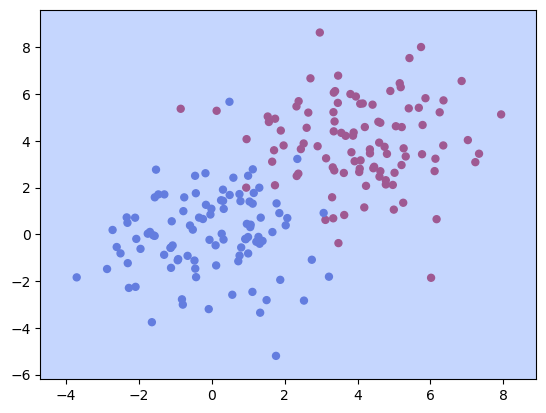

In [24]:
# visualize the decision boundary
plt.scatter(X_two_d[:, 0], X_two_d[:, 1], c=y_two_d, cmap=plt.cm.coolwarm, s=25)

# plot the decision boundary
x_min, x_max = X_two_d[:, 0].min() - 1, X_two_d[:, 0].max() + 1
y_min, y_max = X_two_d[:, 1].min() - 1, X_two_d[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
# plot the line with the learned 
Z = hard_w_two_d.dot(np.c_[xx.ravel(), yy.ravel()].T) + hard_b_two_d
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.5)
plt.show()
